In [15]:
import torch
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

import matplotlib.pyplot as plt

## Getting Tokens and Positions (Visualization Only)

In [4]:
def load_crawled_model(model_dir, model_id):
    """
    Load token and position files for a crawled model.

    Args:
        model_dir (str): Path to the directory containing .pt files.
        model_id (str): Model identifier without file extensions.

    Returns:
        tokens (Tensor), positions (Tensor): Loaded tensors.
    """
    tokens_path = os.path.join(model_dir, f"{model_id}_tokens.pt")
    positions_path = os.path.join(model_dir, f"{model_id}_positions.pt")

    # Check if both files exist
    if not os.path.exists(tokens_path) or not os.path.exists(positions_path):
        raise FileNotFoundError(f"Files not found for model: {model_id}")

    # Load tensors from disk
    tokens = torch.load(tokens_path)
    positions = torch.load(positions_path)

    return tokens, positions

In [8]:
# Example usage
model_dir = os.path.join("..", "crawled_models")  # Directory where .pt files are saved
model_id = 'CarrotKhanStatue__base_000_000_000__checkpoints__final'  # File name prefix

# Load tokens and positions
tokens, positions = load_crawled_model(model_dir, model_id)

In [5]:
tokens

tensor([[-0.0902, -0.0635],
        [ 0.1001,  0.1045],
        [ 0.1441,  0.0420],
        ...,
        [-1.0207, -0.4390],
        [-1.5475,  0.4206],
        [-1.0455,  0.3467]])

In [6]:
positions

tensor([[      0,       0,       0],
        [      1,       0,       1],
        [      2,       0,       2],
        ...,
        [6098117,      15,  524285],
        [6098118,      15,  524286],
        [6098119,      15,  524287]])

## Dataloader Approach

In [10]:
class SaneTokenDataset(Dataset):
    def __init__(self, token_dir, model_ids, window_size=256, halo_size=16, augment=False):
        """
        Dataset that returns windows with halo from crawled SANE token files.

        Args:
            token_dir (str): Path to folder with .pt token and position files.
            model_ids (list[str]): List of model identifiers (filenames without suffix).
            window_size (int): Number of core tokens per window.
            halo_size (int): Number of context tokens before/after.
            augment (bool): Whether to apply augmentations (permutation, noise).
        """
        self.token_dir = token_dir
        self.model_ids = model_ids
        self.window_size = window_size
        self.halo_size = halo_size
        self.augment = augment

        # Load all token/position pairs into memory
        self.models = []
        for mid in self.model_ids:
            tokens = torch.load(f"{token_dir}/{mid}_tokens.pt")       # [N, d_t]
            positions = torch.load(f"{token_dir}/{mid}_positions.pt") # [N, 3]
            self.models.append((tokens, positions))

    def __len__(self):
        # Return total number of samples as number of models
        return len(self.models)

    def __getitem__(self, idx):
        tokens, positions = self.models[idx]
        N = tokens.shape[0]
        total_window = self.window_size + 2 * self.halo_size

        if N < total_window:
            raise ValueError("Model is too small for requested window + halo.")

        # Random start index, ensuring halo fits
        start = random.randint(0, N - total_window)
        end = start + total_window

        window_tokens = tokens[start:end].clone()  # Clone in case we add noise
        window_positions = positions[start:end].clone()

        # Apply simple augmentations
        if self.augment:
            # Permute tokens (as a simple augmentation)
            perm = torch.randperm(window_tokens.shape[0])
            window_tokens = window_tokens[perm]
            window_positions = window_positions[perm]

            # Optionally: add Gaussian noise
            noise = torch.randn_like(window_tokens) * 0.01
            window_tokens += noise

        return {
            "tokens": window_tokens,          # [w + 2h, d_t]
            "positions": window_positions,    # [w + 2h, 3]
        }


### Example Usage of Dataloader

In [14]:
token_dir = "../crawled_models"
model_ids = ["CarrotKhanStatue__base_000_000_000__checkpoints__final", "CarrotKhanStatue__compound_090_000_090__checkpoints__final"]  # List of available models

dataset = SaneTokenDataset(
    token_dir=token_dir,
    model_ids=model_ids,
    window_size=256,
    halo_size=16,
    augment=True
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

### Visualize Dataloader

#### What augmentation = True does:

- Permutation (incl. Halo) gets disordered (shuffling)
- Normal Distributed noise with std = 0.01 is added

Still missing (according to SANE-Paper):

- Position Perturb
- Token Masking

Token shape: torch.Size([288, 2])
Position shape: torch.Size([288, 3])

First 5 tokens:
 tensor([[ 0.6581,  0.0076],
        [-0.5623,  0.2724],
        [ 0.4614, -0.5403],
        [-0.2011,  0.9580],
        [ 0.4776,  0.6086]])

First 5 positions:
 tensor([[5687284,      15,  113452],
        [5687389,      15,  113557],
        [5687363,      15,  113531],
        [5687298,      15,  113466],
        [5687236,      15,  113404]])


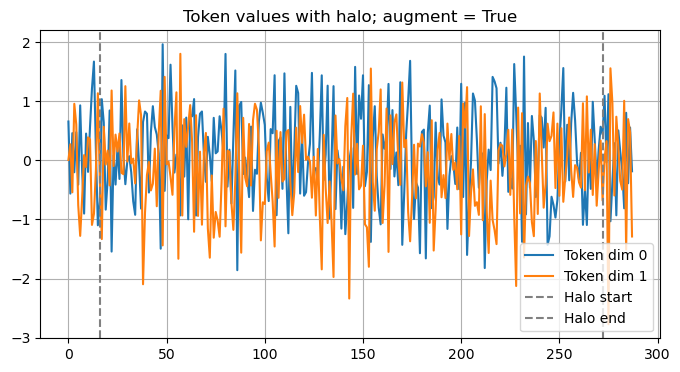

In [37]:
# setup augmentation
augment = True

# === Load dataset ===
dataset = SaneTokenDataset(
    token_dir="../crawled_models",
    model_ids=["CarrotKhanStatue__base_000_000_000__checkpoints__final"],         # Use one model for testing
    window_size=256,
    halo_size=16,
    augment=augment                  # Try both True/False
)

# === Inspect a single sample ===
sample = dataset[0]

tokens = sample["tokens"]         # Shape: [256 + 2*16, 2]
positions = sample["positions"]   # Shape: same

print("Token shape:", tokens.shape)
print("Position shape:", positions.shape)

# Print first few tokens and positions
print("\nFirst 5 tokens:\n", tokens[:5])
print("\nFirst 5 positions:\n", positions[:5])

# Plot the token values (for visualization)
tokens_np = tokens.numpy()
plt.figure(figsize=(8, 4))
plt.plot(tokens_np[:, 0], label="Token dim 0")
plt.plot(tokens_np[:, 1], label="Token dim 1")
plt.axvline(x=16, color='gray', linestyle='--', label="Halo start")
plt.axvline(x=16+256, color='gray', linestyle='--', label="Halo end")
plt.title(f"Token values with halo; augment = {augment}")
plt.legend()
plt.grid(True)
plt.show()
